# HPR CN vs APOL1 expression association analysis

In [1]:
#Loading modules:
import pandas as pd
import numpy as np
import time as tm
import os
import dxdata
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [2]:
#apol1:
DATASET_ID = "REDACTED"
dataset = dxdata.load_dataset(id=DATASET_ID)
olinkdata = dataset['olink_instance_0']
field_apol1 = olinkdata.find_field(name="apol1")
field_eid = olinkdata.find_field(name="eid")
apol1 = olinkdata.retrieve_fields(engine=dxdata.connect(), fields=[field_eid, field_apol1], coding_values="replace")
apol1 = apol1.toPandas()
apol1.set_index("eid", inplace=True)
apol1 = apol1.squeeze()

In [13]:
#HPR CN:
fn = "/mnt/project/qsw/tmp_data/ukb_full_hpr_cnv_chr16_72060344_72078024.tsv.gz"
cnv = pd.read_csv(fn, sep="\t", index_col=0)

In [4]:
#Population:
ans = pd.read_csv("/mnt/project/Datasets/Ancestry/panukbb_ancestry.txt", sep="\t", index_col=0)
ans.rename(columns={"pop":"population"}, inplace=True) #original bad naming..
ans.set_index("individual_id", inplace=True)
ans = ans[~ans.index.duplicated(keep="first")]
ans.index = ans.index.astype(str).astype(object)

In [ ]:
cnv.index = cnv.index.astype(str)
cnv = cnv.join(apol1, how="left")
cnv = cnv.join(ans.population, how="left")

In [16]:
oth = cnv[cnv.population!="AFR"]
display((oth.hardcall!=2).value_counts())
afr = cnv[cnv.population=="AFR"]
display((afr.hardcall!=2).value_counts())

False    482807
True        797
Name: hardcall, dtype: int64

False    4621
True     2072
Name: hardcall, dtype: int64

In [17]:
#Confirming that there is an AFR specific CN variation:
for p in cnv.population.unique():
    st = cnv[cnv.population==p]
    print (p)
    display((st.hardcall!=2).value_counts())

EUR


False    424078
True        138
Name: hardcall, dtype: int64

nan


Series([], Name: hardcall, dtype: int64)

AFR


False    4621
True     2072
Name: hardcall, dtype: int64

EAS


False    2769
True        4
Name: hardcall, dtype: int64

CSA


False    8987
True        6
Name: hardcall, dtype: int64

MID


False    1543
True       59
Name: hardcall, dtype: int64

AMR


False    970
True      19
Name: hardcall, dtype: int64

In [54]:
#Visualize CN in table:
tb = cnv.groupby(["population","hardcall"]).size().unstack().fillna(0).astype(int)
tb

hardcall,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,17.0
population,,,,,,,,,,,,,,,
AFR,4621,61,109,263,981,390,71,56,76,37,16,6,3,2,1
AMR,970,1,5,1,8,4,0,0,0,0,0,0,0,0,0
CSA,8987,2,1,2,1,0,0,0,0,0,0,0,0,0,0
EAS,2769,3,0,1,0,0,0,0,0,0,0,0,0,0,0
EUR,424078,49,24,5,42,11,6,1,0,0,0,0,0,0,0
MID,1543,6,4,8,28,11,1,1,0,0,0,0,0,0,0


In [55]:
#And percentage:
f = (tb.T/tb.sum(axis=1)).T
f

hardcall,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,17.0
population,,,,,,,,,,,,,,,
AFR,0.690423,0.009114,0.016286,0.039295,0.146571,0.058270,0.010608,0.008367,0.011355,0.005528,0.002391,0.000896,0.000448,0.000299,0.000149
AMR,0.980789,0.001011,0.005056,0.001011,0.008089,0.004044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CSA,0.999333,0.000222,0.000111,0.000222,0.000111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EAS,0.998558,0.001082,0.000000,0.000361,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EUR,0.999675,0.000116,0.000057,0.000012,0.000099,0.000026,0.000014,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MID,0.963171,0.003745,0.002497,0.004994,0.017478,0.006866,0.000624,0.000624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [56]:
f = f.T
f.index = f.index.astype(int)
f.index.name = "HPR copy number"

In [57]:
f = f.T
f[16] = 0
f = f.T
f.sort_index(inplace=True)

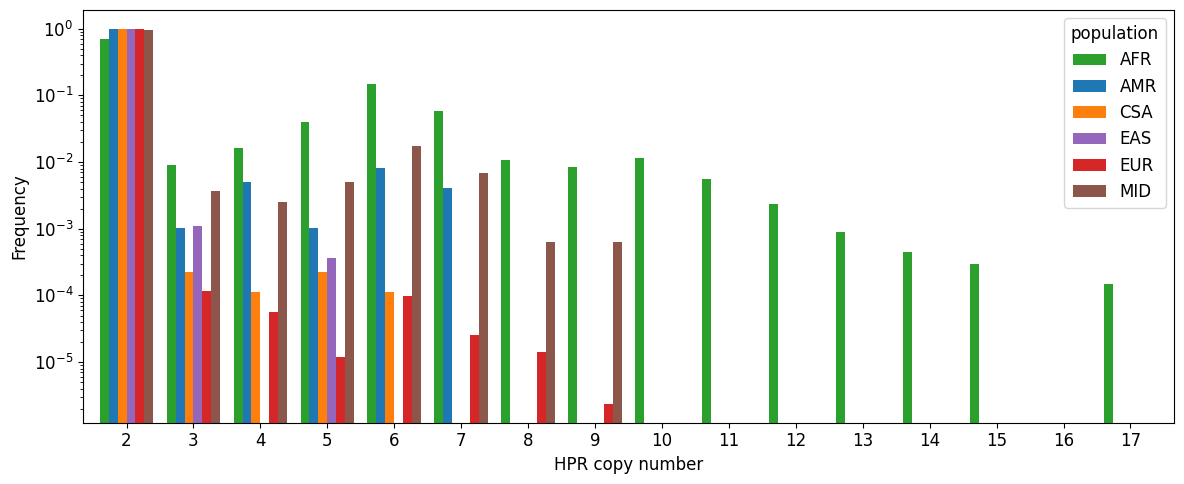

In [58]:
#In a bar plot:
f.plot.bar(logy=True, figsize=(12,5), width=0.8, color=["tab:green", "tab:blue", "tab:orange", "tab:purple", "tab:red", "tab:brown"])
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("hpr_cn_allpop.png", dpi=400)
plt.savefig("hpr_cn_allpop.pdf", dpi=400)
plt.show()
plt.close()

In [60]:
#Comparing EUR vs AFR: 
tb = cnv[(cnv.population=="AFR")|(cnv.population=="EUR")].groupby(["population","hardcall"]).size().unstack().fillna(0).astype(int)
f = (tb.T/tb.sum(axis=1)).T
f = f.T
f.index = f.index.astype(int)
f.index.name = "HPR copy number"

In [61]:
f = f.T
f[16] = 0
f = f.T
f.sort_index(inplace=True)
f

population,AFR,EUR
HPR copy number,,
2,0.690423,0.999675
3,0.009114,0.000116
4,0.016286,0.000057
5,0.039295,0.000012
6,0.146571,0.000099
7,0.058270,0.000026
8,0.010608,0.000014
9,0.008367,0.000002
10,0.011355,0.000000


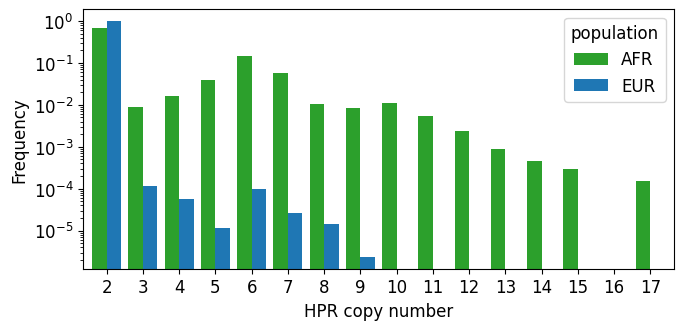

In [63]:
f.plot.bar(logy=True, figsize=(7,3.5), width=0.8, color=["tab:green", "tab:blue"])
plt.ylabel("Frequency")
plt.tight_layout()
plt.xticks(rotation=0)
plt.savefig("hpr_cn_eurafr.png", dpi=400)
plt.savefig("hpr_cn_eurafr.pdf", dpi=400)
plt.show()
plt.close()

In [67]:
#Assoc with APOL1 exp:
#AFR:
afr = cnv[cnv.population=="AFR"]
afr = afr[~afr.apol1.isna()]
afr.hardcall.value_counts().sort_index()
#>10 => merge at 11
afr["x"] = np.minimum(afr.hardcall, 11)
st = afr.groupby(["x"]).apol1.agg(["mean", "sem", "count"])

In [68]:
st

,mean,sem,count
x,,,
2.0,1.278198,0.033426,567
3.0,1.181778,0.347852,9
4.0,0.996514,0.151108,22
5.0,1.422361,0.149996,32
6.0,1.507357,0.064310,123
7.0,1.283272,0.139205,32
8.0,1.253971,0.214615,12
9.0,1.683970,0.371933,5
10.0,2.054075,0.303852,10


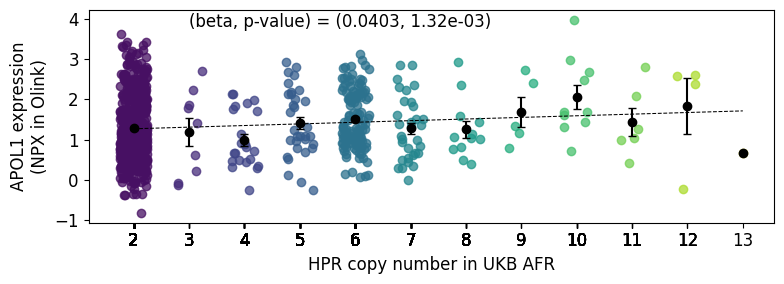

In [113]:
from matplotlib.cm import viridis
import seaborn as sns
from scipy import stats

np.random.seed(4)
afr["rd"] = (np.random.rand(afr.shape[0])-0.5)/2
afr.loc[afr.hardcall==13,"rd"]=0 #for n=1 count
plt.figure(figsize=(8,3))
afr.sort_values(by="hardcall", ascending=True, inplace=True)
for i, cn in enumerate(afr.hardcall.unique()):
    subset = afr[afr.hardcall==cn]
    plt.scatter(subset.hardcall + subset.rd, subset.apol1, color=viridis((i+0.5)/len(afr.hardcall.unique())), alpha=0.75)
    mean = subset.apol1.mean()
    se = subset.apol1.sem()
    plt.errorbar([cn], mean, yerr=se, fmt='o', color='black', capsize=3)
    slope, intercept, r_value, p_value, std_err = stats.linregress(afr.hardcall, afr.apol1)
x_vals = np.array([2,13])  # Get the x-axis limits for plotting the line
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='black', linestyle='--', linewidth=0.75)
plt.text(x=3, y=3.8, s="(beta, p-value) = ({:.4f}, {:.2e})".format(slope, p_value), fontsize=12)
plt.xticks(afr.hardcall, afr.hardcall.astype(int))
plt.xlabel("HPR copy number in UKB AFR")
plt.ylabel("APOL1 expression\n(NPX in Olink)")
plt.tight_layout()
plt.savefig("hpr_cn_regression.png", dpi=400)
plt.savefig("hpr_cn_regression.pdf", dpi=400)
plt.show()